In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, LeakyReLU, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [10]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape, x_test.shape) 

(60000, 28, 28) (10000, 28, 28)


In [11]:
# Flatten data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [12]:
# Latent dimensionality
latent_dim = 100

In [15]:
# Get the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation='tanh')(x)
    
    model = Model(i, x)
    return model

def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

In [16]:
discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

generator = build_generator(latent_dim)

z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)
combined_model = Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

/home/mirsaidml/anaconda3/envs/genAI/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [30]:
# Train the GAN
# Hyperparameters
batch_size = 32
epochs = 500
sample_period = 200 # every `sample_period` steps generate and save some data

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [31]:
for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    
    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    d_losses_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_losses_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_losses_real + d_losses_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    
    # Train the generator
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}, d_acc: {d_acc:.2f}")
    
    if epoch % sample_period == 0:
         sample_images(epoch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
epoch: 1, d_acc: 0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Check gpu working
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

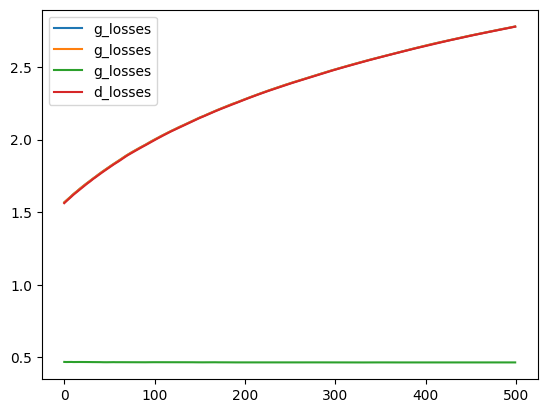

In [32]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

In [33]:
# Generate a random image
rows, cols = 2, 3
noise = np.random.randn(rows * cols, latent_dim)
imgs = generator.predict(noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [34]:
!ls gan_images

0.png  200.png	400.png


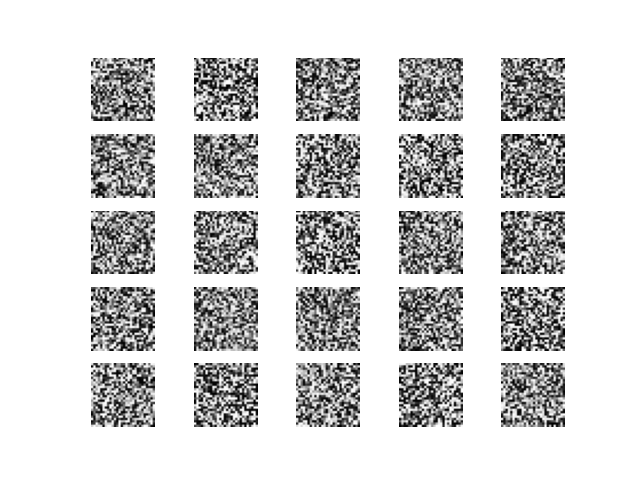

In [39]:
# Show image using IPYTHON
from IPython.display import Image, display
display(Image(filename='gan_images/400.png'))